In [2]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import *
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Model
import tensorflow_docs as tfdocs
from keras.optimizers import *
from PIL import Image
from keras.layers import *
import pathlib
from glob import glob
import os
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  Obtaining dependency information for tensorflow_docs from https://files.pythonhosted.org/packages/54/bc/baf662694e1deeac50432dfe48254d550c9e9d6021ab2fec7de98381da80/tensorflow_docs-2023.5.24.56664-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 13.0 MB/s eta 0:00:00


In [10]:
def load_paths():
    """ 
    * Load the paths to all images in the dataset
    """
    base_path = "/kaggle/input/archaeologicalsites/data"
    images_pattern = os.path.join(base_path, '*', '*.jpg')
    image_paths = [*glob(images_pattern)]
    classes = {p.split(os.path.sep)[-2] for p in image_paths}
    return image_paths, classes

def load_image_and_label(image_paths, target_size=(299, 299)):
    """
    * Load images and labels from list of file paths.

    * Parameters: reame
        - image_paths: dataset path from directory.
        - target_size: image height and width.

    * Return:
        - Numpy array --> array(features, labels).
    """

    images = []
    labels = []

    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

def build_network(base_model, classes):
    """
    build a new network from a pre-trained model

    parameters:
        -base_model: pretraind model 
        -classes: number of classes to classify
    
    """
    for layer in base_model.layers:
        layer.trainable = False

    num_classes = len(classes)

    x = base_model.output
    x = Flatten()(base_model.output)
    x = Dense(units=1024)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=num_classes)(x)
    output = Softmax()(x)
    return models.Model(inputs=base_model.input, outputs=output)


def augmenter(x_train, y_train, batch_size=30):
    data_generator = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2, 
    fill_mode='nearest'
    )

    train_generator = data_generator.flow(x_train, y_train, batch_size)
    return train_generator

def plot_model_history(model_history, metric, val_metric, title):
    """
    * plot and save a model's training curve
    """
    plt.plot(model_history.history[metric])
    plt.plot(model_history.history[val_metric])
    plt.title(title)
    plt.show()

def plot_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
SEED = 999
np.random.seed(SEED)

EPOCHS = 70 
BATCH_SIZE = 32 

#Load the dataset into memory, normalizing the images and one-hot encoding the labels
image_paths, classes = load_paths()
x, y = load_image_and_label(image_paths)
x = x.astype('float') / 255.0
y = LabelBinarizer().fit_transform(y)

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.2, random_state=SEED)

model = build_network(base_model, classes)
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])
train_generator = augmenter(x_train, y_train, batch_size=BATCH_SIZE)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/Users/dareenhanash/Downloads/ArchaeologicalSites-main/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


Model saved to: /Users/dareenhanash/Downloads/ArchaeologicalSites-main/model_inceptionV3_2.h5


In [5]:
hist = model.fit(train_generator, validation_data=(x_test, y_test), epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/70
86/86 [==============================] - 71s 713ms/step - loss: 1.2731 - accuracy: 0.6413 - val_loss: 1.3458 - val_accuracy: 0.7176
Epoch 2/70
86/86 [==============================] - 55s 635ms/step - loss: 0.7674 - accuracy: 0.7440 - val_loss: 0.5393 - val_accuracy: 0.8384
Epoch 3/70
86/86 [==============================] - 54s 631ms/step - loss: 0.6300 - accuracy: 0.7830 - val_loss: 0.4935 - val_accuracy: 0.8297
Epoch 4/70
86/86 [==============================] - 54s 632ms/step - loss: 0.5560 - accuracy: 0.8044 - val_loss: 4.0271 - val_accuracy: 0.5109
Epoch 5/70
86/86 [==============================] - 55s 637ms/step - loss: 0.4973 - accuracy: 0.8176 - val_loss: 0.4459 - val_accuracy: 0.8399
Epoch 6/70
86/86 [==============================] - 54s 631ms/step - loss: 0.4637 - accuracy: 0.8303 - val_loss: 0.4487 - val_accuracy: 0.8457
Epoch 7/70
86/86 [==============================] - 54s 625ms/step - loss: 0.4373 - accuracy: 0.8543 - val_loss: 0.4418 - val_accuracy: 0.8501

In [7]:
model_save_path = '/kaggle/working/model_inceptionV3_30.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /kaggle/working/model_inceptionV3_30.h5


In [6]:
result = model.evaluate(x_test, y_test)
print(f'Test accuracy: {result[1]}')


22/22 [==============================] - 3s 121ms/step - loss: 0.4212 - accuracy: 0.8603
Test accuracy: 0.8602620363235474


In [8]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

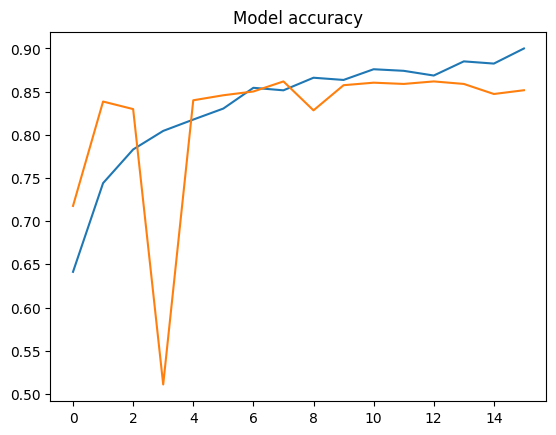

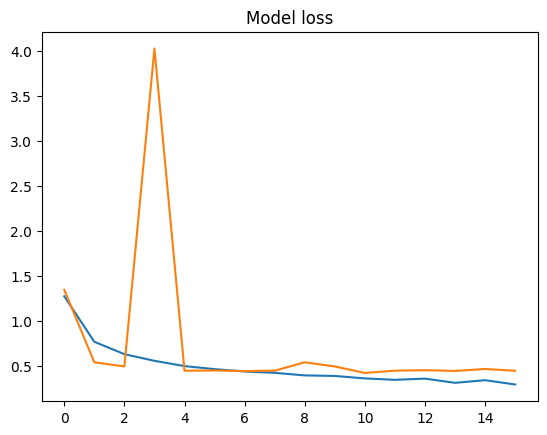

In [12]:
plot_model_history(hist, 'accuracy', 'val_accuracy', "Model accuracy")
plot_model_history(hist, 'loss', 'val_loss', "Model loss")

22/22 [==============================] - 4s 122ms/step


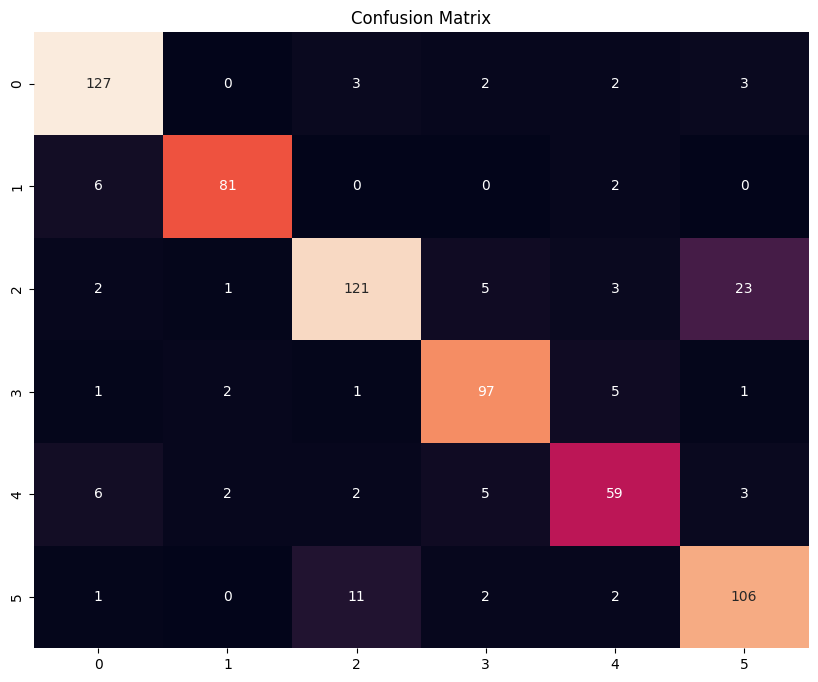

In [13]:
plot_confusion_matrix(model, x_test, y_test)

In [14]:

classes_list = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]  
#{'Ajloun', 'Jerash', 'Petra', 'Roman_amphitheater', 'Umm_Qais', 'WadiRum'}



In [18]:
def test_single_image(model, test_image_path, classes):
  
    test_image = load_img(test_image_path, target_size=(299, 299))
    test_image_array = img_to_array(test_image)
    test_image_array = test_image_array / 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)

    predictions = model.predict(test_image_array)
    predicted_class_index = np.argmax(predictions)
    print(predicted_class_index)
    predicted_class = classes[predicted_class_index]


    plt.imshow(test_image)
    plt.title(f"Predicted class: {predicted_class}")
    plt.show()


1/1 [==============================] - 1s 1s/step
2


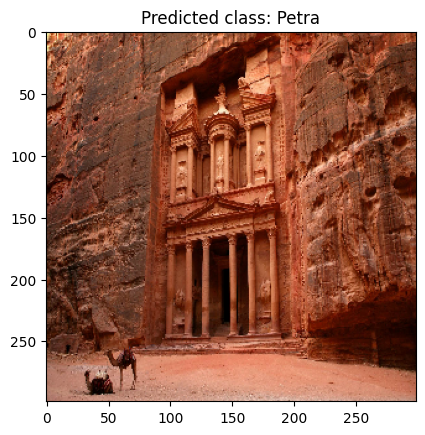

In [19]:
# test1 
test_image_path ="/kaggle/input/test-data/test_petra.jpg"
test_single_image(model, test_image_path, classes_list)


1/1 [==============================] - 0s 28ms/step
4


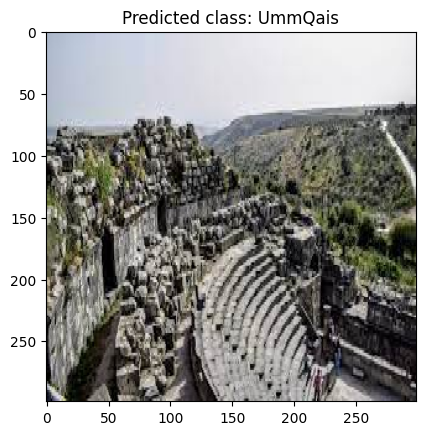

In [21]:
# test2
test_image_path ="/kaggle/input/test-data/Um_qais_test.jpg"
test_single_image(model, test_image_path, classes_list)

1/1 [==============================] - 0s 27ms/step
1


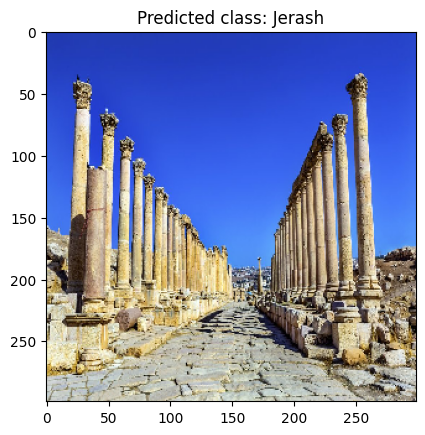

In [22]:
# test3 
test_image_path ="/kaggle/input/test-data/jerash_test2.jpg"
test_single_image(model, test_image_path, classes_list)

1/1 [==============================] - 0s 27ms/step
3


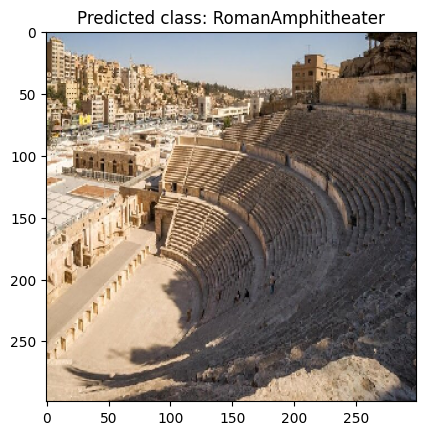

In [24]:
# test4
test_image_path ="/kaggle/input/test-data/roman1.jpg"
test_single_image(model, test_image_path, classes_list)

1/1 [==============================] - 0s 27ms/step
0


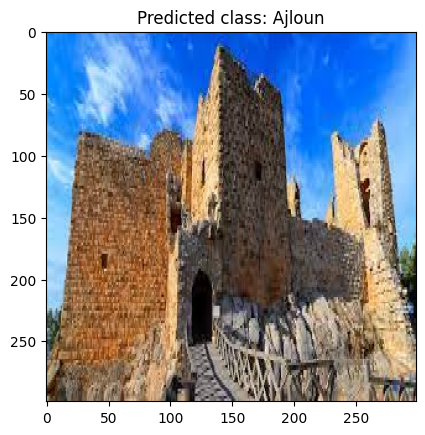

In [25]:
# test4
test_image_path ="/kaggle/input/test-data/ajloun.jpeg"
test_single_image(model, test_image_path, classes_list)

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert one-hot encoded labels to integer labels for y_test (if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy*100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=classes))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

22/22 [==============================] - 3s 119ms/step
Accuracy: 86.03%
Classification Report:
                    precision    recall  f1-score   support

           WadiRum       0.89      0.93      0.91       137
Roman_amphitheater       0.94      0.91      0.93        89
            Jerash       0.88      0.78      0.83       155
          Umm_Qais       0.87      0.91      0.89       107
             Petra       0.81      0.77      0.79        77
            Ajloun       0.78      0.87      0.82       122

          accuracy                           0.86       687
         macro avg       0.86      0.86      0.86       687
      weighted avg       0.86      0.86      0.86       687

Confusion Matrix:
[[127   0   3   2   2   3]
 [  6  81   0   0   2   0]
 [  2   1 121   5   3  23]
 [  1   2   1  97   5   1]
 [  6   2   2   5  59   3]
 [  1   0  11   2   2 106]]


In [28]:
result = model.evaluate(x_test, y_test)
print(f'Test accuracy: {result[1]}')

22/22 [==============================] - 3s 117ms/step - loss: 0.4212 - accuracy: 0.8603
Test accuracy: 0.8602620363235474
